# Demonstration of recentred algorithm with 49 w planes

## Reference:

Ye, H. (2019). Accurate image reconstruction in radio interferometry (Doctoral thesis). https://doi.org/10.17863/CAM.39448

Haoyang Ye, Stephen F Gull, Sze M Tan, Bojan Nikolic, Optimal gridding and degridding in radio interferometry imaging, Monthly Notices of the Royal Astronomical Society, Volume 491, Issue 1, January 2020, Pages 1146–1159, https://doi.org/10.1093/mnras/stz2970

Github: https://github.com/zoeye859/Imaging-Tutorial

In [1]:
%matplotlib notebook
import numpy as np
from scipy.optimize import leastsq, brent
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from time import process_time
from numpy.linalg import inv
np.set_printoptions(precision=16)
from Imaging_core_new import *
from Gridding_core import *
import pickle
with open("min_misfit_gridding_14.pkl", "rb") as pp:
    opt_funcs = pickle.load(pp)

### 1. Read in the data

In [2]:
#########  Read in visibilities ##########
data = np.genfromtxt('simul3d.csv', delimiter = ',')
jj = complex(0,1)
u_original = data.T[2][1:]
v_original = data.T[3][1:]
w_original = data.T[4][1:]
V_original = data.T[5][1:] + jj*data.T[6][1:]
n_uv = len(u_original)
uv_max = max(np.sqrt(u_original**2+v_original**2))
V,u,v,w = Visibility_minusw(V_original,u_original,v_original,w_original)

#### Determine the pixel size ####
X_size = 300 # image size on x-axis (after cropping)
Y_size = 300 # image size on y-axis (after cropping)
# The following are actually the minimum and maximum values of the direction cosines
#  at the edges of the cropped map. They are not the same as the normalized map coordinates
#  used in the theory section.
X_min = -1.15/2 #You can change X_min and X_max in order to change the pixel size.
X_max = 1.15/2
X = np.linspace(X_min, X_max, num=X_size+1)[0:X_size]
Y_min = -1.15/2 #You can change Y_min and Y_max in order to change the pixel size.
Y_max = 1.15/2
Y = np.linspace(Y_min,Y_max,num=Y_size+1)[0:Y_size]
pixel_resol_x = 180. * 60. * 60. * (X_max - X_min) / np.pi / X_size
pixel_resol_y = 180. * 60. * 60. * (Y_max - Y_min) / np.pi / Y_size
print ("The pixel size on x-axis is ", pixel_resol_x, " arcsec") 

The pixel size on x-axis is  790.681757280536  arcsec


# Theory
The dirty map is given by
\begin{equation}\label{eqn:dirty-map}
\boldsymbol{d}(l,m)=\sum_k\boldsymbol{W}_k\boldsymbol{v}_k\exp\left[i2\pi\left(u_k l + v_k m + w_k(n-1)\right)\right]
\end{equation}
In this equation, the visibility plane coordinates are measured in wavelengths and $(l,m,n)$ are direction cosines of the 
observation point which satisfy $n=\sqrt{1-l^2-m^2}$. The full region to be mapped (before image cropping) is chosen to be $l_{\rm{min}}\le l\le l_{\rm{max}}$ and $m_{\rm{min}}\le m\le m_{\rm{max}}$ where without loss of generality we may assume that 
$l_{\rm{min}}=-l_{\rm{max}}$ and $m_{\rm{min}}=-m_{\rm{max}}$. We then write the map limits as $|l|\le l_{\rm{range}}/2$ and
$|m|\le m_{\rm{range}}/2$ where the ranges are the differences between the maximum and minimum values.

We introduce normalized map coordinates $x=l/l_{\rm{range}}$ and $y=m/m_{\rm{range}}$ which each lie within $[-0.5,0.5]$. The conjugate visibility plane coordinates to these are $u'=u l_{\rm{range}}$ and $v'=v m_{\rm{range}}$. In the $w$ direction, we introduce $z=(n-n_0)/n_{\rm{range}}$ and $w'=w n_{\rm{range}}$ where the quantities $n_0$ and $n_{\rm{range}}$ will be defined later. With this notation, the dirty map can be rewritten as
$$
\boldsymbol{d}(x,y)=\sum_k\boldsymbol{W}_k\boldsymbol{v}_k\exp\left[i2\pi\left(u'_k x + v'_k y + w'_k z + w_k (n_0-1)\right)\right]
$$
If $n_0=1$, the plane $z=0$ is tangential to the celestial sphere whereas a value of $n_0<1$ may be used to offset the plane. It is useful to associate the last part of the phase factor with the visibility:
$$
\boldsymbol{d}(x,y)=\sum_k\boldsymbol{W}_k\boldsymbol{v}_k\exp[w_k (n_0-1)] \exp\left[i2\pi\left(u'_k x + v'_k y + w'_k z \right)\right]
$$
Although this resembles a three dimensional Fourier transform, it is only evaluated on $(x,y)$ while $z$ is calculated from $x$ and $y$ according to 
\begin{equation}\label{eq:z-on-sphere}
z = \frac{\sqrt{1-l^2-m^2}-n_0}{n_{\rm range}} = \frac{\sqrt{1-(x l_{\rm{range}})^2-(y m_{\rm{range}})^2}-n_0}{n_{\rm{range}}}
\end{equation}

According to the theory of convolutional gridding, we can find a gridding convolutional function $C(u')$ and an associated grid correction function $h(x)$ so that this can be well approximated by:

\begin{equation}\label{eq:gridded-dirty-map}
\boldsymbol{d}(x,y)\approx
h(x)h(y)h(z)\sum_{t\in\mathbb{Z}} \left[\sum_{r\in\mathbb{Z}}\sum_{s\in\mathbb{Z}}
G_{rst}\mathrm{e}^{i2\pi r x} 
\mathrm{e}^{i2\pi s y}
\right]\mathrm{e}^{i2\pi t z}
\end{equation}
where
$$G_{rst}=
\sum_k \boldsymbol{W}_k\boldsymbol{v}_k\exp[w_k (n_0-1)] C(r-u'_k)  C(s-v'_k) C(t-w'_k).$$
This indicates that each weighted visibility should be multiplied by $\exp[w_k (n_0-1)]$ before being convolved in all three directions using the separable product $C(u')C(v')C(w')$ of gridding functions in each direction. Two of the inverse Fourier transforms, those along the $x$ and $y$ directions can be performed using the FFT algorithm, since they need to be evaluated on uniformly spaced grids. The final inverse transform (involving $t$) is not evaluated on a uniformly spaced grid of $z$ points and is not computed using the FFT.

Instead, the equation relating $z$ to $x$ and $y$ is used to find the phase factors $\exp(i2\pi t z(x,y))$ which are multiplied by the two-dimensional FFTs while they are summed up.  

The values of $l_{\rm{range}}$ and $m_{\rm{range}}$ are set by the region of the sky to be mapped. Since the convolutional gridding function $C$ is designed so that high accuracy is achieved within $|x|\leq x_0$ and $|y|\leq y_0$, the map is finally cropped to $|l|\leq x_0 l_{\rm{range}}$ and $|m|\leq x_0 m_{\rm{range}}.$ One would in practice determine $l_{\rm{range}}$ and $m_{\rm{range}}$ needed to give the desired final size.
The numbers of points $N_x\times N_y$ for the two-dimensional FFTs are chosen so that they cover the non-zero terms in the sums over $r$ and $s$ in equation for the gridded dirty map. This requires that $N_x\geq (u_{\rm{max}} - u_{\rm{min}})l_{\rm{range}}+W$ and $N_y\geq (v_{\rm{max}} - v_{\rm{min}})m_{\rm{range}}+W$ where $u$ and $v$ are measured in wavelengths and $W$  defines the support of the gridding functions ($C$ vanishes outside the interval $[-W/2, W/2]$).

It finally remains to determine the values of $n_0$ and $n_{\rm{range}}$, which will also determine the number of sheets in the $w$-stack (i.e., the number of non-zero terms in the sum over $t$). If we use the same gridding convolution and correction functions in all three directions, the results will be accurate within $|x|\leq x_0$, $|y|\leq x_0$ and $|z|\leq x_0$. From the equation $z(x,y)$ for the celestial sphere, we see that $z$ is maximum at the map center where $x=y=0$ and is a minimum at the corners of the map where $x=y=x_0$. In particular, 
$$z_{\rm{max}} = \frac{1-n_0}{n_{\rm{range}}}\quad\text{and}\quad
z_{\rm{min}} = \frac{\sqrt{1-(x_0 l_{\rm{range}})^2-(x_0 m_{\rm{range}})^2}-n_0}{n_{\rm{range}}}$$

In order to best use the region of accuracy of the gridding convolution function, we choose $z_{\rm{min}}=-x_0$ and $z_{\rm{max}}=x_0$. This leads to
$$n_{\rm{range}} = \frac{1-\sqrt{1-(x_0 l_{\rm{range}})^2-(x_0 m_{\rm{range}})^2}}{2x_0}\quad\text{and}\quad
n_0=1-x_0 n_{\rm{range}}$$
which are the promised expressions for the quantities used in the above.

In the previous version of this code, we chose $z_{\rm{min}}=-x_0$ and $z_{\rm{max}}=0$ which places $z=0$ at the center of the map. With this choice
$$n_{\rm{range}} = \frac{1-\sqrt{1-(x_0 l_{\rm{range}})^2-(x_0 m_{\rm{range}})^2}}{x_0}\quad\text{and}\quad
n_0=1$$

The separation between the layers in the $w$-stack is $1/n_{\rm{range}}$ wavelengths and so the minimum of number of layers required is
\begin{equation}\label{eq:N_{w'}+W}
N_{w'} = N_z \geq n_{\rm{range}}(w_{\rm{max}}-w_{\rm{min}}) + W
\end{equation}
where the additional $W$ layers are necessary to allow for the support of the gridding function.


### 2. Determine stack of w values to use

In [3]:
# Choose the support of the optimal gridding function to use. 
#  (These have been precomputed)
W = 14
M, x0, h = opt_funcs[W].M, opt_funcs[W].x0, opt_funcs[W].h

n0, w_values, dw = calcWgrid_offset(W, X_max, Y_max, w, x0, symm=True)

We will have 49 w-planes


### 3 3D Gridding + Imaging + Correcting

To know more about gridding, you can refer to https://github.com/zoeye859/Imaging-Tutorial 
#### Calculating gridding values for w respectively

In [4]:
Nfft = 600
im_size = 600

ind = find_nearestw(w_values, w)
C_w = cal_grid_w(w, w_values, ind, dw, W, h, M)

Elapsed time during the w gridding value calculation in seconds: 1.3474449999999998


#### Gridding on w-axis

In [5]:
V_wgrid, u_wgrid, v_wgrid, beam_wgrid = grid_w_offset(V, u, v, w, C_w, w_values, W, len(w_values), ind, n0)

Elapsed time during the w-gridding calculation in seconds: 0.6592219999999998


#### Imaging

In [6]:
I_size = int(im_size*2*x0)
I_image = np.zeros((I_size,I_size),dtype = np.complex_)
B_image = np.zeros((I_size,I_size),dtype = np.complex_)

t2_start = process_time() 
for w_ind in range(len(w_values)):
    print ('Gridding the ', w_ind, 'th level facet out of ', len(w_values),' w facets.\n')
    V_update = np.asarray(V_wgrid[w_ind])
    u_update = np.asarray(u_wgrid[w_ind])
    v_update = np.asarray(v_wgrid[w_ind])
    beam_update = np.asarray(beam_wgrid[w_ind])
    V_grid, B_grid = grid_uv(V_update, u_update, v_update, beam_update, W, im_size, X_max, X_min, Y_max, Y_min, h, M)
    print ('FFT the ', w_ind, 'th level facet out of ', len(w_values),' w facets.\n')
    I_image += FFTnPShift_offset(V_grid, w_values[w_ind], X, Y, im_size, x0, n0)
    B_image += FFTnPShift_offset(B_grid, w_values[w_ind], X, Y, im_size, x0, n0)
    B_grid = np.zeros((im_size,im_size),dtype = np.complex_) 
    V_grid = np.zeros((im_size,im_size),dtype = np.complex_)
    
t2_stop = process_time()   
print("Elapsed time during imaging in seconds:", t2_stop-t2_start)  

Gridding the  0 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.05122899999999975
Elapsed time during the u/v gridding value calculation in seconds: 0.05002200000000023
FFT the  0 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  1 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.15016499999999944
Elapsed time during the u/v gridding value calculation in seconds: 0.1636160000000002
FFT the  1 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  2 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.28674399999999967
Elapsed time during the u/v gridding value calculation in seconds: 0.2907440000000001
FFT the  2 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding 

FFTing...
Phaseshifting...
Gridding the  25 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.350970000000018
Elapsed time during the u/v gridding value calculation in seconds: 0.35560700000002043
FFT the  25 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  26 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.31812599999997815
Elapsed time during the u/v gridding value calculation in seconds: 0.31118699999998967
FFT the  26 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTing...
Phaseshifting...
Gridding the  27 th level facet out of  49  w facets.

Elapsed time during the u/v gridding value calculation in seconds: 0.27208000000001675
Elapsed time during the u/v gridding value calculation in seconds: 0.2811629999999923
FFT the  27 th level facet out of  49  w facets.

FFTing...
Phaseshifting...
FFTi

#### Rescale and display uncorrected map

<IPython.core.display.Javascript object>


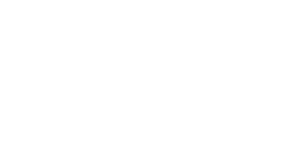

(0.1480703475738338+1.771551347820669e-17j)

In [7]:
I_image_now = image_rescale(I_image,im_size, n_uv)
B_image_now = image_rescale(B_image,im_size, n_uv)
plt.figure()
plt.imshow(np.rot90(I_image_now.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.title('Dirty map before any gridding correction')
B_image_now[150,150]

#### Apply correcting functions h(x)h(y) along x and y axis

In [8]:
Nfft = 600
# Use these for calculating gridding correction on the FFT grid
M = 32
I_xycorrected = xy_correct(I_image_now, opt_funcs[W], im_size, x0=0.25)
B_xycorrected = xy_correct(B_image_now, opt_funcs[W], im_size, x0=0.25)

<IPython.core.display.Javascript object>


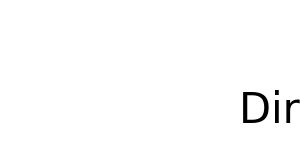

(0.1480703475738338+1.771551347820669e-17j)

In [9]:
plt.figure()
plt.imshow(np.rot90(I_xycorrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.title('Dirty map after gridding correction in x and y directions')
B_xycorrected[150,150]

#### Correcting function on z axis

In [10]:
lut = setup_lookup_table(opt_funcs[14], Nfine=256, degree=7)
Cor_gridz = z_correct_cal_offset(lut, X_min, X_max, Y_min, Y_max, dw, h, im_size, W, M, x0, n0)
I_zcorrected = z_correct(I_xycorrected, Cor_gridz, im_size, x0=0.25)
B_zcorrected = z_correct(B_xycorrected, Cor_gridz, im_size, x0=0.25)

<IPython.core.display.Javascript object>


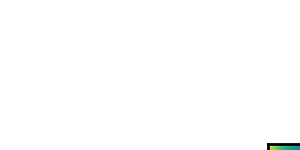

Text(0.5, 1.0, 'Gridding Correction in z direction')

In [11]:
plt.figure()
plt.imshow(np.rot90(Cor_gridz,1), origin = 'lower')
plt.colorbar()
plt.title("Gridding Correction in z direction")

<IPython.core.display.Javascript object>


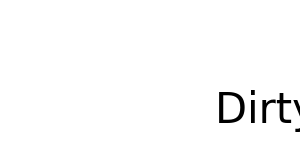

(1+1.1964254672511677e-16j)

In [12]:
plt.figure()
plt.imshow(np.rot90(I_zcorrected.real,1), origin = 'lower')
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.title('Dirty map after gridding correction in x, y and z directions')
B_zcorrected[150,150]

### 4 DFT and FFT dirty image difference

In [13]:
I_DFT = np.loadtxt('I_DFT_simul300.csv', delimiter = ',')

<IPython.core.display.Javascript object>


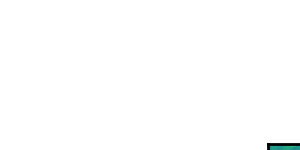

In [14]:
I_dif = I_DFT - I_zcorrected.real
rms = RMS(I_dif, im_size, 0.5, x0=0.25)
plt.figure()
plt.imshow(np.rot90(I_dif,1), origin = 'lower')
plt.colorbar()
plt.xlabel('Image Coordinates X')
plt.ylabel('Image Coordinates Y')
plt.title('Difference from DFT map')
plt.show()

In [15]:
print (rms)

2.8797445860217816e-15
